In [61]:
pip install --upgrade pandas

  Using cached pandas-2.1.4-cp310-cp310-win_amd64.whl.metadata (18 kB)
Using cached pandas-2.1.4-cp310-cp310-win_amd64.whl (10.7 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.0
    Uninstalling pandas-1.4.0:
      Successfully uninstalled pandas-1.4.0
Note: you may need to restart the kernel to use updated packages.


In [35]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from scipy.optimize import curve_fit

In [62]:
# Original DataFrame
df = pd.DataFrame({'A': [1, 2], 'B': [3, 4]})

# Row to append
new_row = pd.Series({'A': 5, 'B': 6})

# Use pd.concat to append the row
df = pd.concat([df, new_row.to_frame().T], ignore_index=True)

# Display the updated DataFrame
print(df)

   A  B
0  1  3
1  2  4
2  5  6


In [66]:
# gathering all the data
df_age_causes = pd.DataFrame()
for i in [
    'all-causes',\
    'communicable-maternal-perinatal-nutritional-conditions',\
    'noncommunicable-diseases',\
    'Injuries',\
    'ill-defined-diseases',\
]:
    df = pd.read_csv(f"data/{i}.csv")
    df.drop([
        'Age Group',\
        'Percentage of cause-specific deaths out of total deaths',\
        'Region Code',\
        'Region Name',\
        'Country Name',\
            ], axis=1, inplace=True)
    df = df.rename(columns={'Death rate per 100 000 population':'Death rate'})
    # cleaning the data frames
    df_reduced = pd.DataFrame()
    df_reduced = df[(df['Year'] > 1959) & (df['Year'] < 2020)]
    df_reduced = df_reduced[df_reduced['Age group code'] != 'Age_unknown']
    # final data frame
    df_reduced =  df_reduced[(df_reduced['Country Code'] == 'JPN') | (df_reduced['Country Code'] == 'CHE')]
    df_reduced['causes'] = i
    df_age_causes = pd.concat([df_age_causes, df_reduced], ignore_index=True)

In [67]:
df = pd.read_csv("data/all-causes.csv")
df.drop([
    'Age Group',\
    'Percentage of cause-specific deaths out of total deaths',\
    'Region Code',\
    'Region Name',\
    'Country Name',\
        ], axis=1, inplace=True)
df = df.rename(columns={'Death rate per 100 000 population':'Death rate'})
# cleaning the data frame
df_reduced = pd.DataFrame()
df_reduced = df[(df['Year'] > 1959) & (df['Year'] < 2020)]
df_reduced = df_reduced[df_reduced['Age group code'] != 'Age_unknown']
# final data frame
df_reduced =  df_reduced[(df_reduced['Country Code'] == 'JPN') | (df_reduced['Country Code'] == 'CHE')]
df_reduced['causes'] = "all_causes"
df_age_causes = pd.concat([df_age_causes, df_reduced], ignore_index=True)

In [68]:
# classify years by 10
from utils import year_classification
df_age_causes['Year'] = df_age_causes['Year'].apply(year_classification)

# dividing the data into ten year period data frames
df_1960_1970 = df_age_causes[df_age_causes['Year'] == "1960-1970"]
df_1970_1980 = df_age_causes[df_age_causes['Year'] == "1970-1980"]
df_1980_1990 = df_age_causes[df_age_causes['Year'] == "1980-1990"]
df_1990_2000 = df_age_causes[df_age_causes['Year'] == "1990-2000"]
df_2000_2010 = df_age_causes[df_age_causes['Year'] == "2000-2010"]
df_2010_2020 = df_age_causes[df_age_causes['Year'] == "2010-2020"]

# transforming the data frames and putting them in a dictionary to make data analysis
unique_ages = sorted(df_age_causes['Age group code'].unique())
unique_genders = sorted(df_age_causes['Sex'].unique())
unique_causes = sorted(df_age_causes['causes'].unique())
unique_countries = sorted(df_age_causes['Country Code'].unique())
dfs = {}
for year in ["1960-1970","1970-1980","1980-1990","1990-2000","2000-2010","2010-2020"] :
    df_extract = df_age_causes[df_age_causes['Year'] == year]
    df_name = f'df_{year}'
    dfs[df_name] = pd.DataFrame(columns = ['age','gender','cause','JPN_death_rate','CHE_death_rate'])
    for age in unique_ages:
        for gender in unique_genders:
            for cause in unique_causes:
                death_jpn = df_extract[
                    (df_extract['Age group code'] == age) &\
                    (df_extract['Sex'] == gender) &\
                    (df_extract['causes'] == cause) &\
                    (df_extract['Country Code'] == 'JPN')
                ]['Death rate'].sum()/10
                death_che = df_extract[
                    (df_extract['Age group code'] == age) &\
                    (df_extract['Sex'] == gender) &\
                    (df_extract['causes'] == cause) &\
                    (df_extract['Country Code'] == 'CHE')
                ]['Death rate'].sum()/10
                new_row = pd.Series({
                    'age':age,
                    'gender':gender,
                    'cause':cause,
                    'JPN_death_rate':death_jpn,
                    'CHE_death_rate':death_che
                })
                dfs[df_name] = pd.concat([dfs[df_name], new_row.to_frame().T], ignore_index=True)
                dfs[df_name]['age'] = dfs[df_name]['age'].apply(lambda x: x.replace("_", "").replace("Age", ""))



In [86]:
# Computing if the differences between women and men in different age groups are significant

significance_age = pd.DataFrame(columns=['year','cause','JPN_significant','CHE_significant'])
unique_causes = sorted(df_age_causes['causes'].unique())
unique_causes.remove('all_causes')
for key, data_frame in dfs.items():
    for cause in unique_causes:
        target = data_frame[data_frame['cause'] == 'all_causes']
        target.drop(target.tail(3).index,inplace = True)

        country = 'CHE_death_rate'
        male_data = target[target['gender'] == 'Male'][country]
        female_data = target[target['gender'] == 'Female'][country]

        print(male_data)

        # # Mann-Whitney U test
        # statistic, p_value = stats.mannwhitneyu(male_data, female_data, alternative='two-sided')

        # # Checking if the difference is significant
        # alpha = 0.05  # Set your desired significance level
        # if p_value < alpha:
        #     j = "Yes"
        # else:
        #     j = "No"
#         country = 'CHE_death_rate'
#         male_data = target[target['gender'] == 'Male'][country]
#         female_data = target[target['gender'] == 'Female'][country]

#         # Mann-Whitney U test
#         statistic, p_value = stats.mannwhitneyu(male_data, female_data, alternative='two-sided')

#         # Checking if the difference is significant
#         alpha = 0.05  # Set your desired significance level
#         if p_value < alpha:
#             c = "Yes"
#         else:
#             c = "No"

#         new_row = {
#             'year': key,
#             'cause': cause,
#             'JPN_significant': j,
#             'CHE_significant': c
#         }

#         significance_age = pd.concat([significance_age, new_row.to_frame().T], ignore_index=True)

# significance_age

14       2175.32513
32       119.584681
50        61.258415
68         47.01992
86       106.156778
104      152.801014
122      138.031126
140      154.472165
158      201.943158
176      312.445307
194      505.961855
212      842.264021
230     1416.480225
248     2289.503171
266     3658.981129
284      5710.10714
302     9055.162832
320    14264.275456
338    24376.470006
Name: CHE_death_rate, dtype: object
14       2175.32513
32       119.584681
50        61.258415
68         47.01992
86       106.156778
104      152.801014
122      138.031126
140      154.472165
158      201.943158
176      312.445307
194      505.961855
212      842.264021
230     1416.480225
248     2289.503171
266     3658.981129
284      5710.10714
302     9055.162832
320    14264.275456
338    24376.470006
Name: CHE_death_rate, dtype: object
14       2175.32513
32       119.584681
50        61.258415
68         47.01992
86       106.156778
104      152.801014
122      138.031126
140      154.472165
158     

In [80]:

# Computing if the differences between women and men in different age groups are significant

significance_age = pd.DataFrame(columns=['year','cause','JPN_significant','CHE_significant'])
unique_causes = sorted(df_age_causes['causes'].unique())
unique_causes.remove('all_causes')
for key, data_frame in dfs.items():
    for cause in unique_causes:
        target = data_frame[data_frame['cause'] == 'all_causes']
        target.drop(target.tail(3).index,inplace = True)

        country = 'JPN_death_rate'
        male_data = target[target['gender'] == 'Male'][country]
        female_data = target[target['gender'] == 'Female'][country]


        # Mann-Whitney U test
        statistic, p_value = stats.mannwhitneyu(male_data, female_data, alternative='two-sided')

        # Checking if the difference is significant
        alpha = 0.05  # Set your desired significance level
        if p_value < alpha:
            j = "Yes"
        else:
            j = "No"
        country = 'CHE_death_rate'
        male_data = target[target['gender'] == 'Male'][country]
        female_data = target[target['gender'] == 'Female'][country]


        # Mann-Whitney U test
        statistic, p_value = stats.mannwhitneyu(male_data, female_data, alternative='two-sided')

        # Checking if the difference is significant
        alpha = 0.05  # Set your desired significance level
        if p_value < alpha:
            c = "Yes"
        else:
            c = "No"

        new_row = {
            'year': key,
            'cause': cause,
            'JPN_significant': j,
            'CHE_significant': c
        }

        significance_age = pd.concat([significance_age, new_row.to_frame().T], ignore_index=True)

significance_age

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

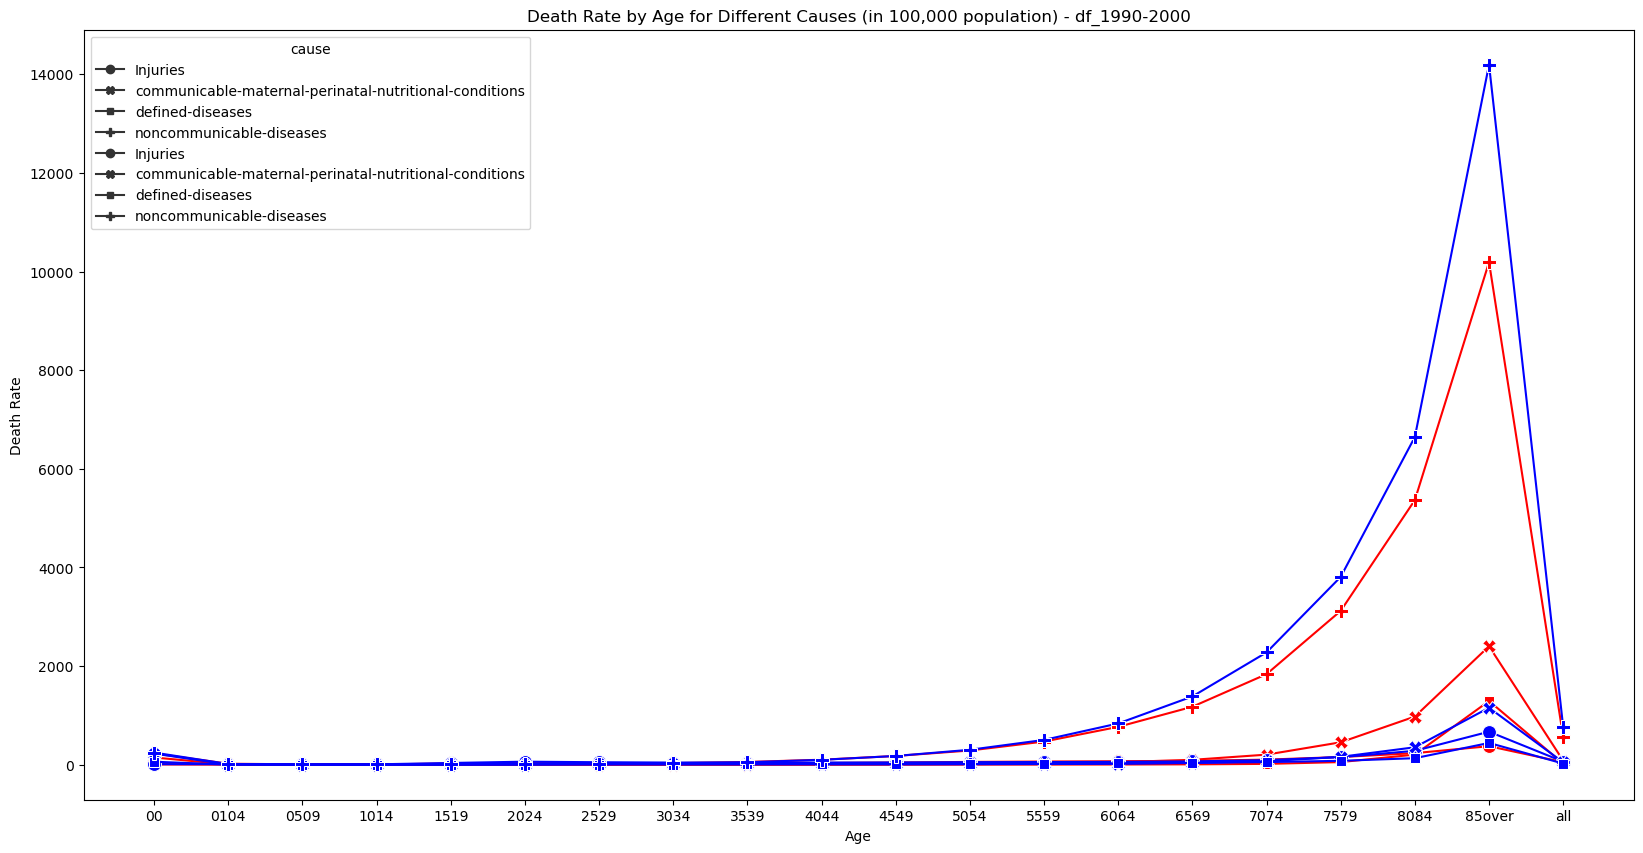

'\nBlue for CHE\nRed for JPN\n\n'

In [10]:
# creating a line plot inside a frame
plt.figure(figsize=(20, 10))  
sns.set_palette(["red", "blue"])
sns.lineplot(data=dfs['df_1990-2000'][
    (dfs['df_1990-2000']['cause'] != 'all_causes') & (dfs['df_1990-2000']['cause'] != 'all-causes') &(dfs['df_1990-2000']['gender'] == 'All')
],x='age', y='JPN_death_rate',style='cause', markers=True, dashes=False, markersize=10)
sns.lineplot(data=dfs['df_1990-2000'][
    (dfs['df_1990-2000']['cause'] != 'all_causes') & (dfs['df_1990-2000']['cause'] != 'all-causes') & (dfs['df_1990-2000']['gender'] == 'All')
], x='age', y='CHE_death_rate',style='cause', markers=True, dashes=False, markersize=10)

plt.xlabel("Age")
plt.ylabel("Death Rate")
plt.title(f"Death Rate by Age for Different Causes (in 100,000 population) - df_1990-2000")

plt.show()

"""
Blue for CHE
Red for JPN

"""


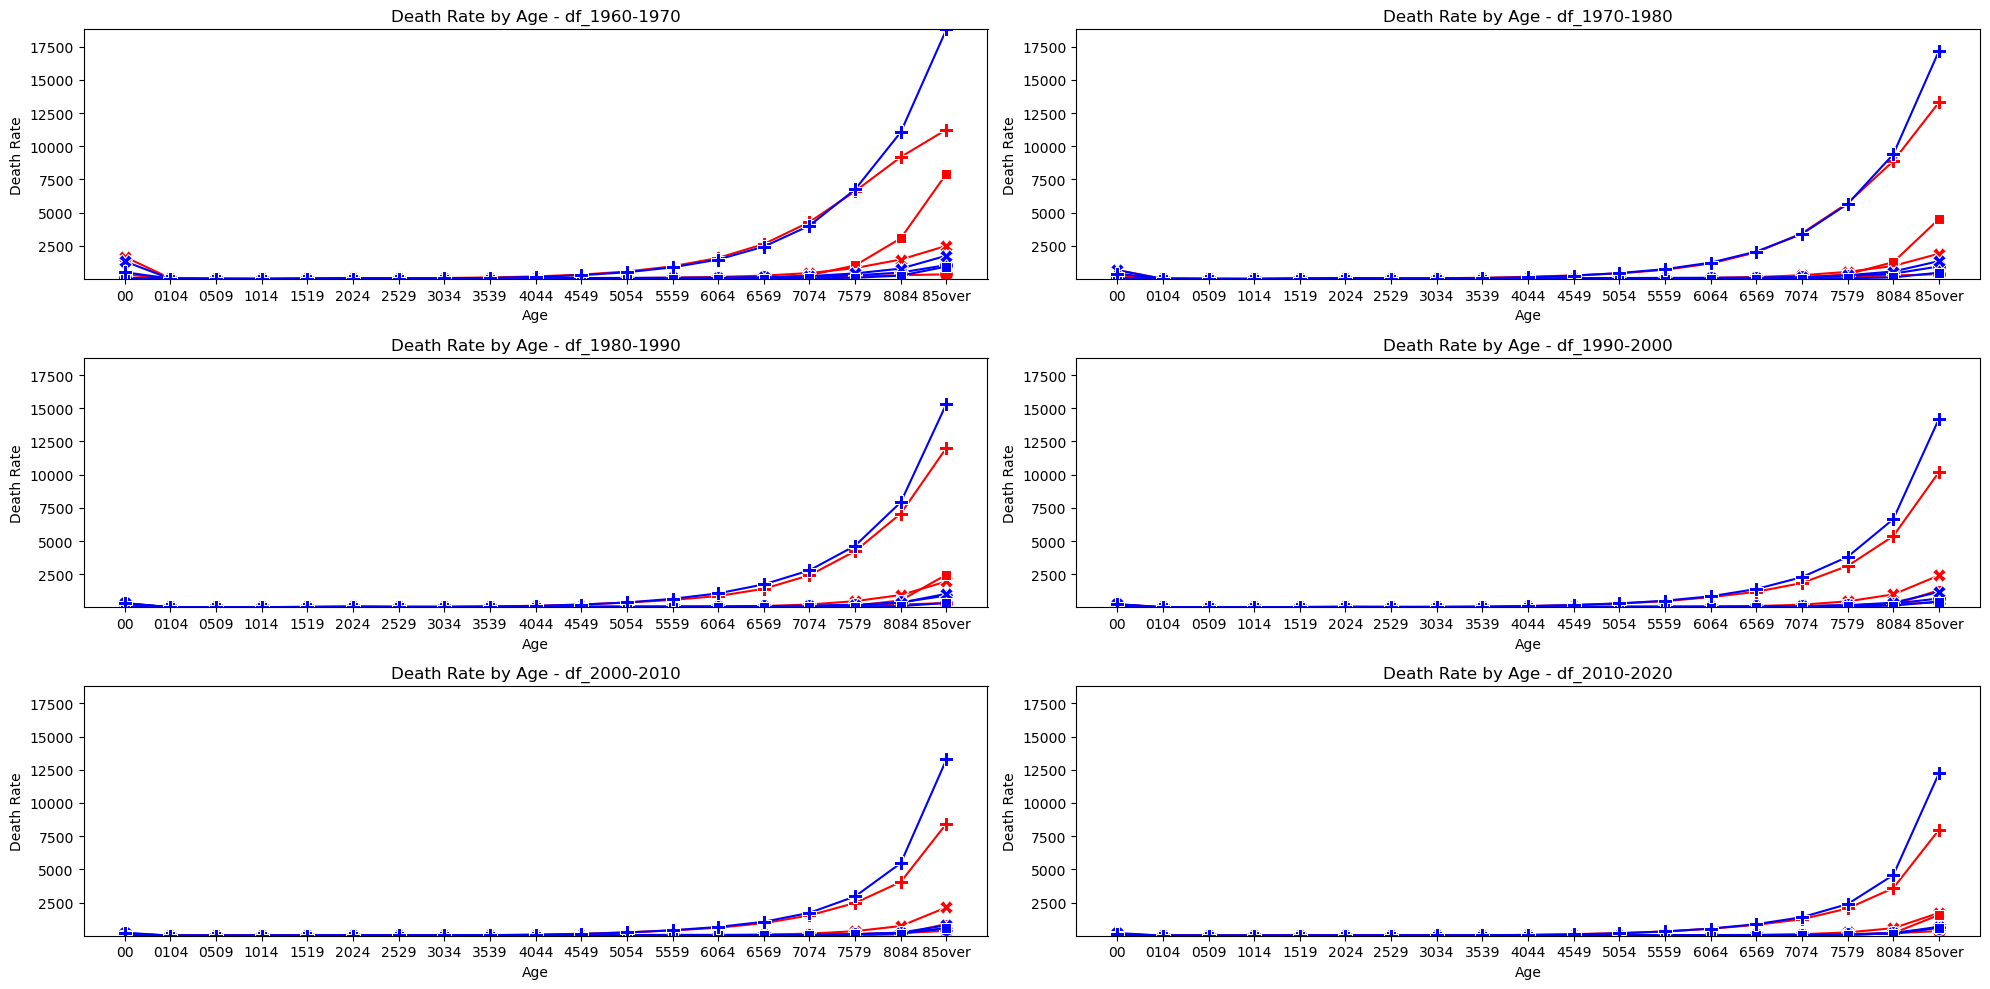

In [11]:

# Define the layout of the subplots (2 rows, 3 columns)
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
axes = axes.flatten()
global_y_min = float('inf')
global_y_max = float('-inf')

for i, (key, df) in enumerate(dfs.items()):
    filtered_df = df[(df['cause'] != 'all-causes') & (df['cause'] != 'all_causes') & (df['gender'] == 'All') & (df['age'] != 'all')]

    local_y_min = filtered_df[['JPN_death_rate', 'CHE_death_rate']].min().min()
    local_y_max = filtered_df[['JPN_death_rate', 'CHE_death_rate']].max().max()

    global_y_min = min(global_y_min, local_y_min)
    global_y_max = max(global_y_max, local_y_max)

    sns.set_palette(["red", "blue"])  
    sns.lineplot(data=filtered_df, x='age', y='JPN_death_rate', style='cause', markers=True, dashes=False, markersize=10, ax=axes[i])
    sns.lineplot(data=filtered_df, x='age', y='CHE_death_rate', style='cause', markers=True, dashes=False, markersize=10, ax=axes[i])

    axes[i].get_legend().remove()

    axes[i].set_ylim(global_y_min, global_y_max)

    axes[i].set_xlabel("Age", fontsize=10)  
    axes[i].set_ylabel("Death Rate")
    axes[i].set_title(f"Death Rate by Age - {key}")

plt.tight_layout()

plt.show()


In [12]:
df_age_causes[
          (df_age_causes['Age group code'] == 'Age85_over') &\
               (df_age_causes['Sex'] == "Male") &\
               (df_age_causes['causes'] == 'noncommunicable-diseases') &\
               (df_age_causes['Country Code'] == 'JPN')
            ]['Death rate'].sum()/60

12659.098411716666

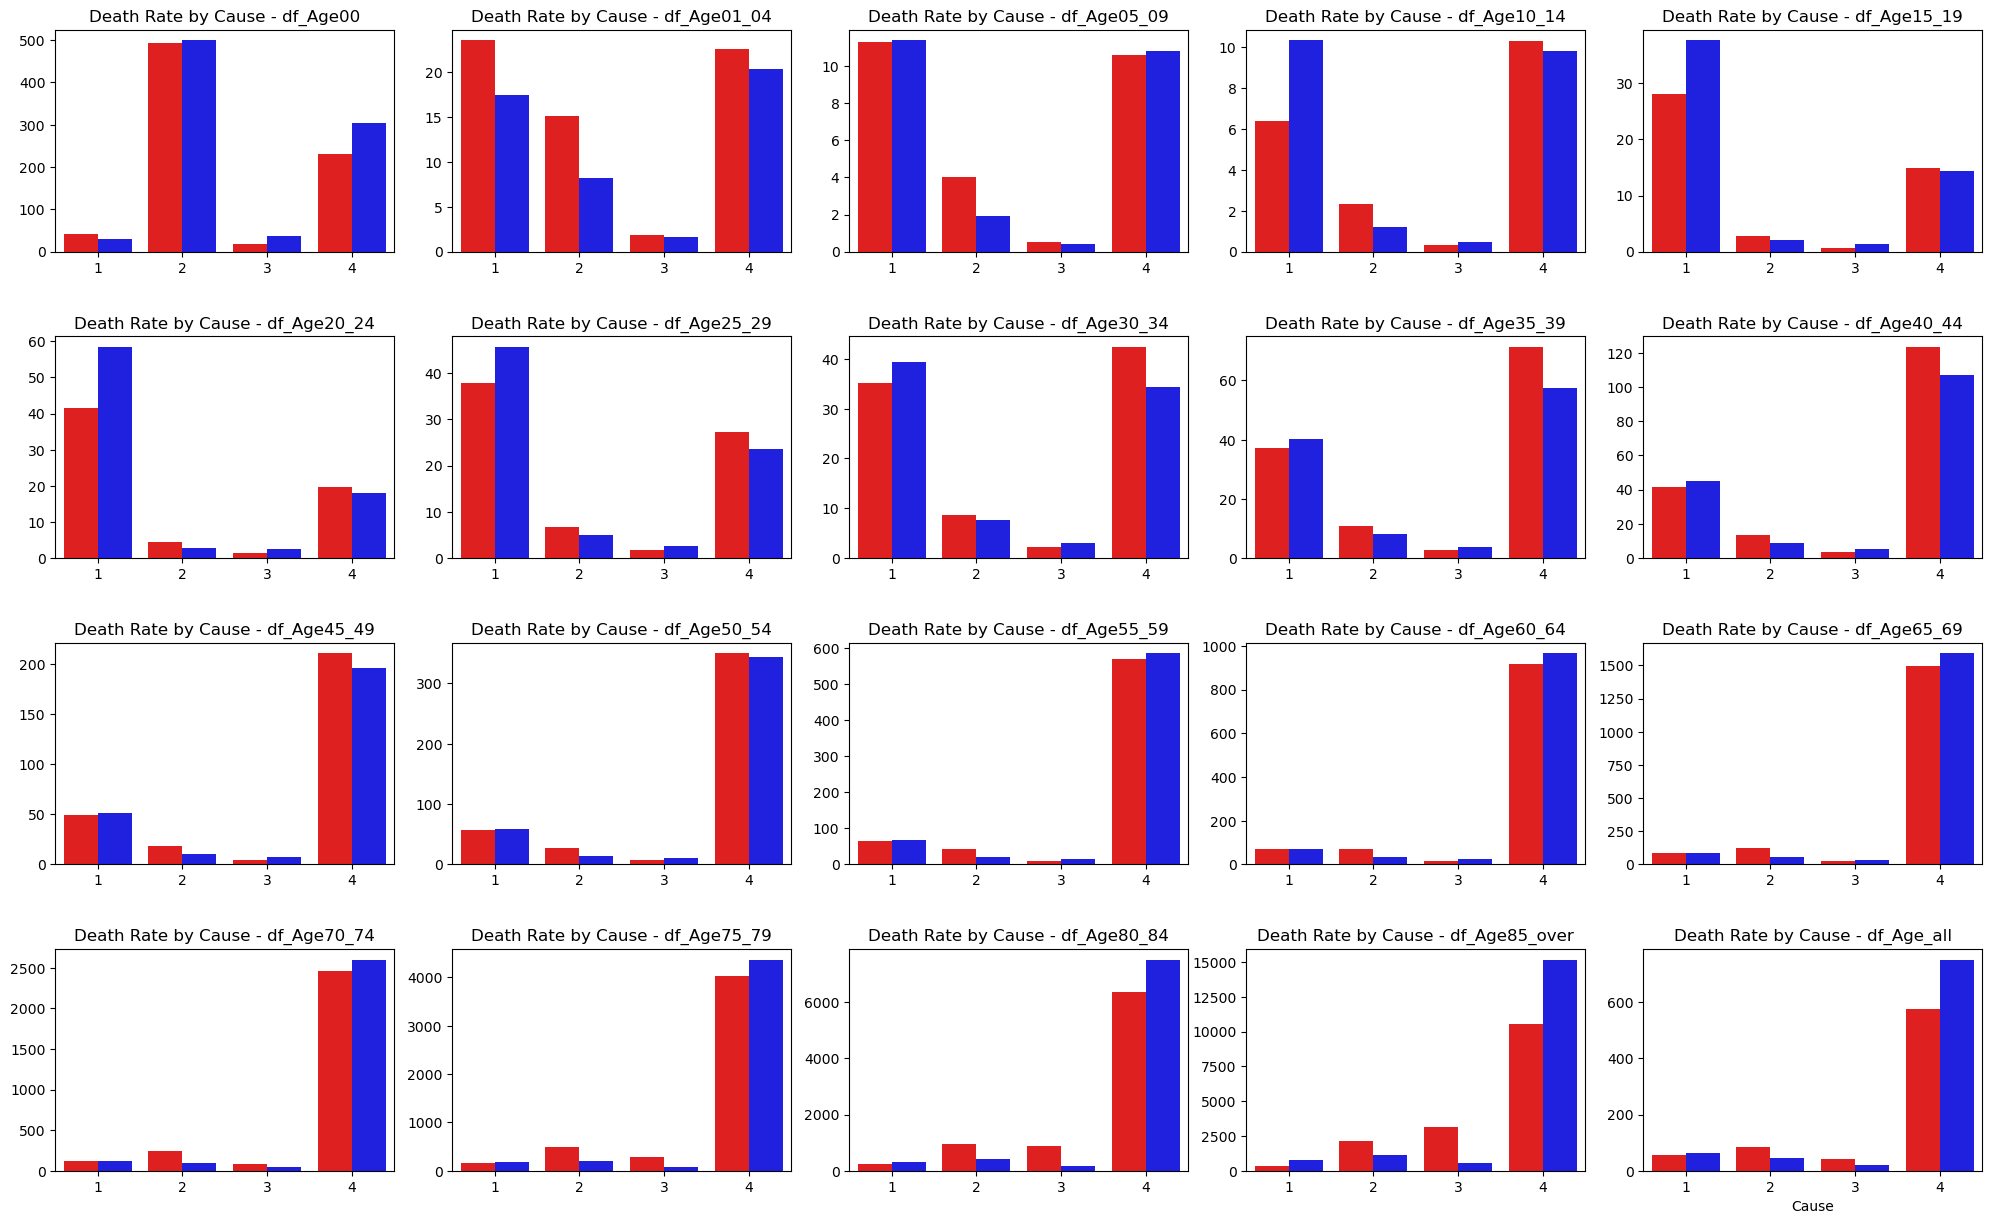

In [13]:
# Barchart for each age, causes-death
unique_years = df_age_causes['Year'].unique()
dfs = {}
df_extract = df_age_causes[df_age_causes['Age group code'] == age]



for age in unique_ages :
     df_extract = df_age_causes[df_age_causes['Age group code'] == age]
     df_name = f'df_{age}'
     dfs[df_name] = pd.DataFrame(columns = ['gender','cause','JPN_death_rate','CHE_death_rate'])
     for gender in unique_genders:
          for cause in unique_causes:
               death_jpn = df_extract[
               (df_extract['Sex'] == gender) &\
               (df_extract['causes'] == cause) &\
               (df_extract['Country Code'] == 'JPN')
               ]['Death rate'].sum()/60
               death_che = df_extract[
               (df_extract['Sex'] == gender) &\
               (df_extract['causes'] == cause) &\
               (df_extract['Country Code'] == 'CHE')
               ]['Death rate'].sum()/60
               new_row = {
               'gender':gender,
               'cause':cause,
               'JPN_death_rate':death_jpn,
               'CHE_death_rate':death_che
               }
               dfs[df_name] = dfs[df_name].append(new_row, ignore_index=True)


fig, axes = plt.subplots(4, 5, figsize=(20, 12))
fig.tight_layout(h_pad=4)

axes = axes.flatten()

for i, (key, df) in enumerate(dfs.items()):
    df = df[(df['cause'] != 'all-causes') & (df['cause'] != 'all_causes') & (df['gender'] == 'All')]

    df_long = df.melt(id_vars=['cause'], value_vars=['JPN_death_rate', 'CHE_death_rate'], var_name='Country', value_name='Death_Rate')

    sns.set_palette(["red", "blue"])  
    sns.barplot(data=df_long, x='cause', y='Death_Rate', hue='Country', ax=axes[i])

    axes[i].set_xticklabels([1,2,3,4]) 
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(f"Death Rate by Cause - {key}")

    axes[i].get_legend().remove()

axes[-1].set_xlabel("Cause")

plt.show()


In [14]:
# line chart for age - all-cause
# the average of death rate(all-causes) in all years

df_extract = df_age_causes[df_age_causes['causes'] == 'all-causes']
df_plot = pd.DataFrame(columns = ['gender','age','JPN_death_rate','CHE_death_rate'])
for age in unique_ages :
     for gender in unique_genders:
               death_jpn = df_extract[
               (df_extract['Sex'] == gender) &\
               (df_extract['Age group code'] == age) &\
               (df_extract['Country Code'] == 'JPN')
               ]['Death rate'].sum()/60
               death_che = df_extract[
               (df_extract['Sex'] == gender) &\
               (df_extract['Age group code'] == age) &\
               (df_extract['Country Code'] == 'CHE')
               ]['Death rate'].sum()/60
               new_row = {
               'gender':gender,
               'age':age,
               'JPN_death_rate':death_jpn,
               'CHE_death_rate':death_che
               }
               df_plot = df_plot.append(new_row, ignore_index=True)
               df_plot['age'] = df_plot['age'].apply(lambda x: x.replace("_", "").replace("Age", ""))



In [15]:
df_filtered = df_plot[df_plot['gender'] == "All"]
df_filtered
df_filtered = df_filtered.reset_index(drop=True)
df_filtered = df_filtered.drop(df_filtered.index[-1])

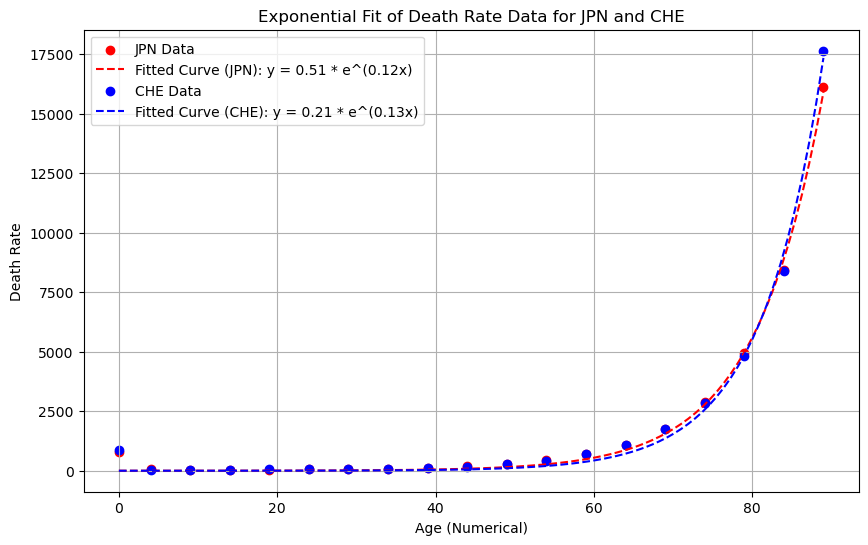

R-squared (JPN): 0.996
R-squared (CHE): 0.994
Correlation (JPN) between Age and Death Rate: 0.67
Correlation (CHE) between Age and Death Rate: 0.65


In [16]:
#converting age groups to integers
for i in range(0,len(df_filtered['age']),) :
     if i > 0 :
          df_filtered.loc[i,'age_linear'] =  4+(i-1)*5
     else:
          df_filtered.loc[i,'age_linear'] = 0


age_groups = df_filtered['age_linear']
death_rates_JPN = df_filtered['JPN_death_rate']
death_rates_CHE = df_filtered['CHE_death_rate']

# Defining the exponential function
def exponential_function(x, a, b):
    return a * np.exp(b * x)

#  initial parameter estimates
initial_guess = (1.0, -0.02)  

# Fitting the curve 
params_JPN, covariance_JPN = curve_fit(exponential_function, age_groups, death_rates_JPN, p0=initial_guess)
a_JPN, b_JPN = params_JPN
params_CHE, covariance_CHE = curve_fit(exponential_function, age_groups, death_rates_CHE, p0=initial_guess)
a_CHE, b_CHE = params_CHE

# Create a range of x values for the curve
x_fit = np.linspace(min(age_groups), max(age_groups), 100)
y_fit_JPN = exponential_function(x_fit, a_JPN, b_JPN)
y_fit_CHE = exponential_function(x_fit, a_CHE, b_CHE)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(age_groups, death_rates_JPN, label="JPN Data", color='red')
plt.plot(x_fit, y_fit_JPN, 'r', label=f'Fitted Curve (JPN): y = {a_JPN:.2f} * e^({b_JPN:.2f}x)', linestyle='--')
plt.scatter(age_groups, death_rates_CHE, label="CHE Data", color='blue')
plt.plot(x_fit, y_fit_CHE, 'b', label=f'Fitted Curve (CHE): y = {a_CHE:.2f} * e^({b_CHE:.2f}x)', linestyle='--')

plt.xlabel('Age (Numerical)')
plt.ylabel('Death Rate')
plt.legend()
plt.title('Exponential Fit of Death Rate Data for JPN and CHE')
plt.grid(True)
plt.show()

# Calculating the R-squared value for the fit for JPN
y_pred_JPN = exponential_function(age_groups, a_JPN, b_JPN)
ssr_JPN = np.sum((death_rates_JPN - y_pred_JPN) ** 2)  # Sum of squares of residuals
sst_JPN = np.sum((death_rates_JPN - np.mean(death_rates_JPN)) ** 2)  # Total sum of squares
r_squared_JPN = 1 - (ssr_JPN / sst_JPN)

y_pred_CHE = exponential_function(age_groups, a_CHE, b_CHE)
ssr_CHE = np.sum((death_rates_CHE - y_pred_CHE) ** 2)  # Sum of squares of residuals
sst_CHE = np.sum((death_rates_CHE - np.mean(death_rates_CHE)) ** 2)  # Total sum of squares
r_squared_CHE = 1 - (ssr_CHE / sst_CHE)

print(f'R-squared (JPN): {r_squared_JPN:.3f}')
print(f'R-squared (CHE): {r_squared_CHE:.3f}')

# Calculate the correlation 
correlation_JPN = np.corrcoef(age_groups, death_rates_JPN)[0, 1]
print(f'Correlation (JPN) between Age and Death Rate: {correlation_JPN:.2f}')

correlation_CHE = np.corrcoef(age_groups, death_rates_CHE)[0, 1]
print(f'Correlation (CHE) between Age and Death Rate: {correlation_CHE:.2f}')


In [17]:
# bar chart for each cause death rate for all years and all ages
# the average of death rate(all-ages) in all years

df_extract = df_age_causes[df_age_causes['Age group code'] == 'Age_all']
df_plot = pd.DataFrame(columns = ['gender','cause','JPN_death_rate','CHE_death_rate'])
for cause in unique_causes :
     for gender in unique_genders:
               death_jpn = df_extract[
               (df_extract['Sex'] == gender) &\
               (df_extract['causes'] == cause) &\
               (df_extract['Country Code'] == 'JPN')
               ]['Death rate'].sum()/60
               death_che = df_extract[
               (df_extract['Sex'] == gender) &\
               (df_extract['causes'] == cause) &\
               (df_extract['Country Code'] == 'CHE')
               ]['Death rate'].sum()/60
               new_row = {
               'gender':gender,
               'cause':cause,
               'JPN_death_rate':death_jpn,
               'CHE_death_rate':death_che
               }
               df_plot = df_plot.append(new_row, ignore_index=True)

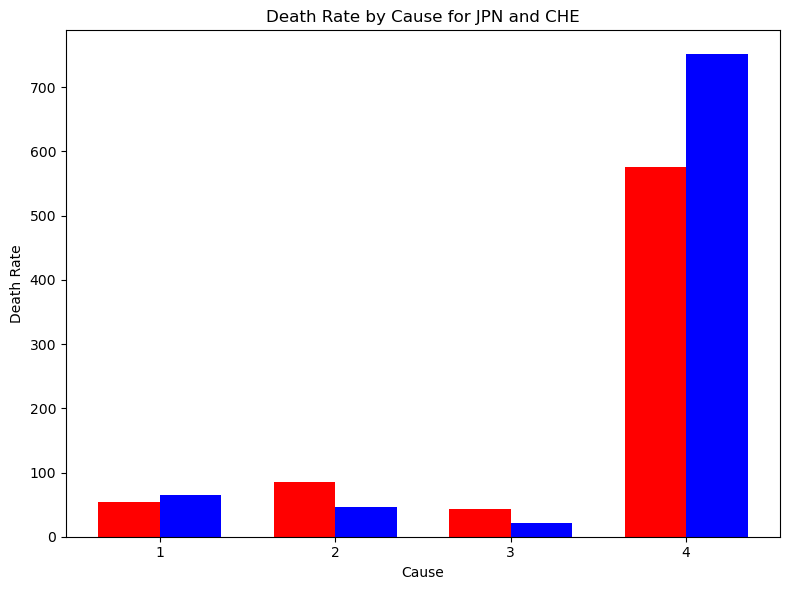

In [18]:

df = df_plot[(df_plot['gender'] == 'All') & (df_plot['cause'] != 'all-causes') & (df_plot['cause'] != 'all_causes')]
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

x = range(len(df['cause']))

# Create bars for JPN_death_rate and CHE_death_rate
ax.bar(x, df['JPN_death_rate'], width, label='JPN', color='red')
ax.bar([i + width for i in x], df['CHE_death_rate'], width, label='CHE', color='blue')

ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels([1,2,3,4]) 

ax.set_xlabel('Cause')
ax.set_ylabel('Death Rate')
ax.set_title('Death Rate by Cause for JPN and CHE')


plt.tight_layout()
plt.show()

# report all-cause just in number'